# README

In this notebook, the author does not seek to build the best model for a specific task. The purpose of this work is to reveal the principles of calibrating some linear machine learning models. We want to introduce you to visualization, calibration, and discrimination of support vectors and deepen your knowledge in this area. Therefore, we leave any experiments with hyperparameter selection, search for the best heuristics, etc. to the reader's discretion.

---


The author of this work does not claim to have the best solutions, so you are always welcome to send your comments or best ideas about the work to the email address listed in the GitHub profile.

# PIP LIST

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, roc_curve, classification_report, RocCurveDisplay,auc, roc_curve
from sklearn.datasets import make_classification, make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


# Block 1: Accuracy vs. Confidence — Why is calibration necessary?


1) In machine learning, accuracy is one of the most common metrics. It shows how often the model guesses the class (“spam” / “not spam”).
However, as has been rightly pointed out, accuracy can be misleading (especially when classes are imbalanced). But even if the accuracy is high, we are left with a second, equally important problem: how much can we trust the model's “confidence”?

2) Let's consider two models, both with the same fairly high accuracy of 90%:

    * Model A (Confident): For 100 predictions, it says “I am 99% sure,” but in fact it is only right in 90 of them.
    *  Model B (Uncertain): For 100 predictions, it says “I am 70% confident,” but it is also correct in 90 of them.

Both models have the same accuracy, but their “confidence” (probability) is useless. We cannot use these 99% or 70% to make decisions because they do not reflect reality.

3) What is calibration? Calibration is an indicator of how closely the probability predicted by the model matches the actual frequency of events.

---

### Definition:
A perfectly calibrated model A model is called perfectly calibrated if, for any prediction $p$ (e.g., “I am 70% confident”), the true proportion of positive cases in that group is indeed $p$ (i.e., 70%). In our example, both models (A and B) would have to predict a “confidence” of about 90%. Why is this important? For risk-weighted decision making, we vitally need honest probabilities:

* Medicine: A 90% probability of recurrence (urgent treatment needed) is not the same as 51% (can be observed).
* Finance: A 95% probability of loan default (reject) is not 55% (can be issued at a high interest rate).
    
Many powerful models, such as Support Vector Machines (SVM), do not inherently produce real probabilities. They simply find the “distance to the boundary.” Logistic regression, on the other hand, often “naturally” calibrates

---

### The purpose of this notebook:

* To clearly show how uncalibrated models can be (using SVM as an example).

* To compare them with a “naturally” calibrated model (logistic regression).

* To study and implement methods for “correcting” this confidence — calibration (Platt Scaling and Isotonic Regression).

* To visualize and measure (using Brier Score) how these methods improve the reliability of predictions.

# Block 2: DATA

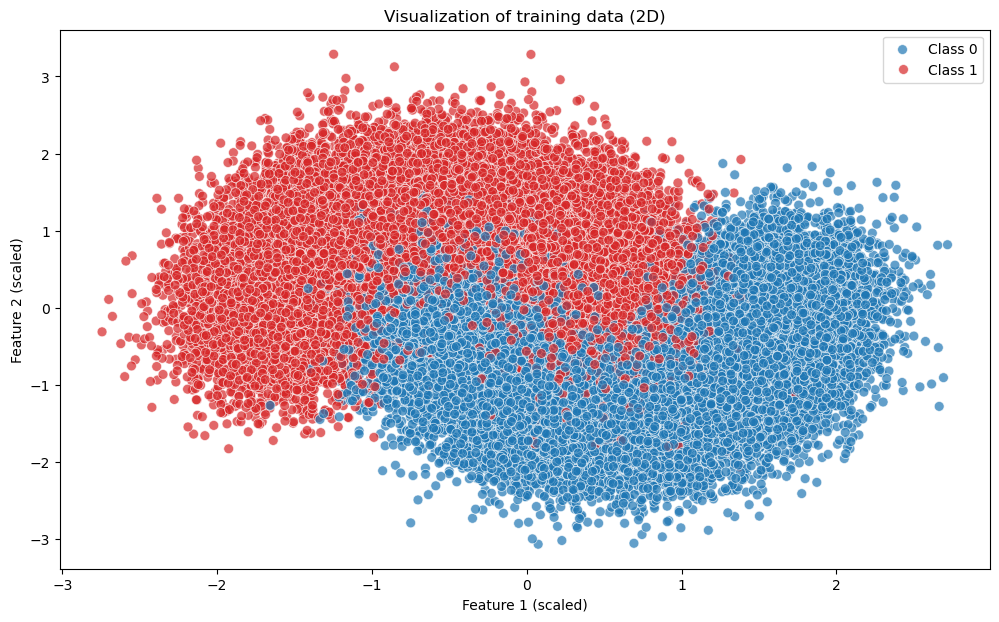

In [2]:
#1. Creating data (two moons)
X, y = make_moons(n_samples=100000, noise=0.30, random_state=42)

# 2. Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Divide into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42
)

# 4. Visualization
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=X_train[:, 0], 
    y=X_train[:, 1], 
    hue=y_train, 
    palette=['#d62728', '#1f77b4'], # Red, Blue
    alpha=0.7,
    s=50
)
plt.title('Visualization of training data (2D)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend(['Class 0', 'Class 1'])
plt.show()

### Graph analysis

As we can see, the data is non-linearly separable.

1.  **Overlap:** In the center (around `x= 0~0.5`, `y= 0~0.5`), the red and blue points are heavily mixed.
2.  **Nonlinearity:** A simple straight line (which both SVM with `kernel=linear` and LogReg will try to construct) will not be able to separate these “half-moons” well.

This is an ideal scenario. Any linear model attempting to draw a boundary here will be forced to compromise and will therefore be *uncertain* in the central region. Our task is to find out how “honestly” the models will report this uncertainty.

# Block 3: Problem — Uncalibrated SVM

Now let's see how a **Support Vector Machine (SVM)** handles our data. We deliberately choose SVM because, by its nature, this model **is not probabilistic**.

* **Logistic regression** (which we will look at later) attempts to model the *probability* $P(y=1 | x)$.
* **SVM** solves the problem differently: it searches for the “maximum margin” (a hyperplane that best separates the classes).

When we ask SVM to predict “confidence,” by default (via `decision_function`) it returns not a probability, but **the signed distance from the point to this separating hyperplane**.

Technical issue: `ValueError` and the [0, 1] requirement

We want to evaluate SVM calibration. To do this, we have two tools:
1.  **Visual:** `CalibrationDisplay` (Reliability chart).
2.  **Metric:** `brier_score_loss`.

The problem is that both of these functions **mathematically require** input values in the range **[0, 1]** because they are designed to work with *probabilities*.

If we try to pass them “distances” (e.g., `+2.7` or `-1.5`), we will get `ValueError: y_prob has values outside [0, 1]`.

How can we convert our “distances” (from $-\infty$ to $+\infty$) into “pseudo-probabilities” (from 0 to 1) so that we can at least *plot a graph* and see the problem?

---

### The “Naive” Solution: Standard Sigmoid

We need a mathematical function that “squashes” any range into [0, 1]. The **standard sigmoid function** (or logistic function) is ideal for this purpose:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

This function is not a random choice. It is the very function that underlies **Logistic Regression** and **Platt Calibration**.

In this block, we will apply a **“naive”** sigmoid. We will not train it, but simply run our “distances” through it. This will allow us to:
1.  Avoid `ValueError`.
2.  Create **“pseudo-probabilities”**.
3.  Visualize how bad this **untrained** calibration is.

---

### IMPORTANT DIFFERENCE: “Naive” Sigmoid vs. “Smart” Platt Calibration

 `SVC(probability=True)` does “the same thing.” But there is a **critical difference** between what we are doing now and what `probability=True` does.

1.  **Naive Sigmoid (What we are doing):**
    * We use $f(x) = \text{sigmoid}(x)$.
    * The parameters are “hard-coded” ($A=1, B=0$).
    * We do **not train** this function. We simply apply it to the outputs of `decision_function`.
    * **Result:** We get an S-shaped (overconfident) curve because this “naive” function does not know how to *correctly* map distances to probabilities.

2.  **Platt's calibration (what `probability=True` or `CalibratedClassifierCV` does):**
    * It uses $f(x) = \text{sigmoid}(A \cdot x + B)$.
    * It **trains** the parameters $A$ and $B$ on the holdout sample (inside `fit()`).
    * It selects $A$ (slope) and $B$ (offset) so that the resulting curve is **as close as possible to the ideal diagonal**.
* **Result:** A well-calibrated model.

In [3]:
raw_svm_model = SVC(kernel='rbf', probability=False, random_state=42)
raw_svm_model.fit(X_train, y_train)
pred_raw_svm = raw_svm_model.decision_function(X_test)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_pseudo_proba = sigmoid(pred_raw_svm)

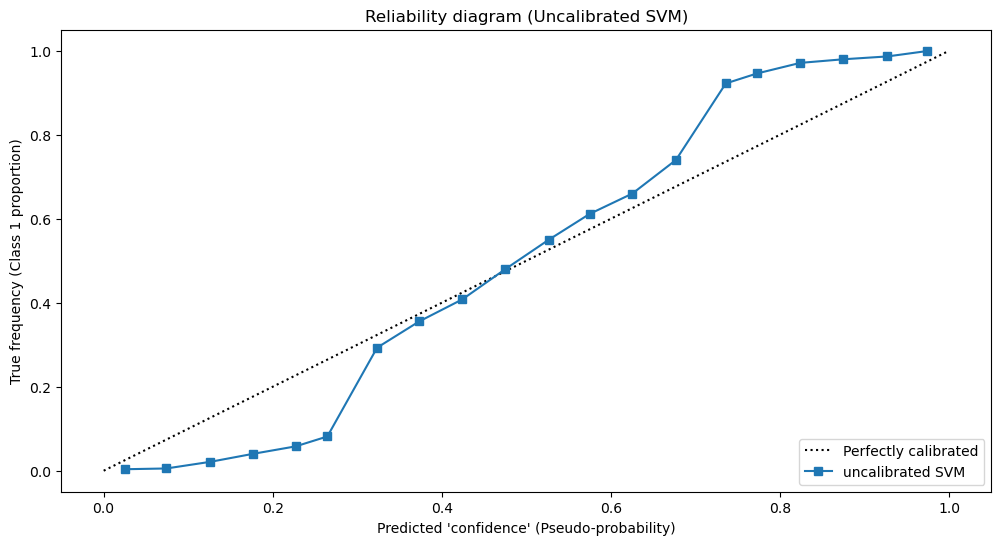

In [4]:
fig, ax = plt.subplots(figsize=(12,6))

CalibrationDisplay.from_predictions(
    y_test,
    y_pseudo_proba,
    n_bins=20,
    ax=ax,
    strategy="uniform",
    name="uncalibrated SVM",
)
ax.set_title('Reliability diagram (Uncalibrated SVM)')
ax.set_xlabel("Predicted 'confidence' (Pseudo-probability)")
ax.set_ylabel("True frequency (Class 1 proportion)")
plt.show()

In [5]:
brier_svm_raw = brier_score_loss(y_test, y_pseudo_proba)
print(f"Brier Loss: {brier_svm_raw:.4f}")

Brier Loss: 0.0861


### Analysis of results

### 1)  Reliability diagram:

* Perfect calibration is represented by a dotted diagonal line (“Perfectly Calibrated”).
* Our SVM (blue line) has an "s" shape. She is especially unfaithful at the ends. with more samples the curve will become more and more uniformly shaped like the letter "S".

#### What this means?
* Line BELOW the diagonal = **Overconfidence***  The model predicts higher than reality.
* Line ABOVE the diagonal = **Underconfidence***  The model predicts lower than reality.

### Analysis based on your observations:**
* When the forecast is `0.1` - `0.4`: The line is **BELOW** the diagonal. The model is **over-confident**.
* With a forecast of `0.4`–`0.65`: the line is **in the vicinity of the ideal curve**.
* With a forecast of `0.65` - `1.0`: The line is **ABOVE** the diagonal again. The model is **under-confident** again.

---
### 2) Metric (Brier Score):
* We obtained a Brier Loss of **0.0861**.
* At first glance, this is a pretty satisfactory result (much closer to 0 than to 0.25). This is because the Brier Score measures two aspects simultaneously:
1.  ##### Discrimination
    (the ability to distinguish between classes): SVM with an `rbf` kernel excellently separated our “moons,” demonstrating good discrimination. This *improves* (lowers) the Brier Score.
3.  ##### Calibration
    (reliability of probabilities): We evaluate this aspect using a graph.

#### Main conclusion:
We have shown that a “naive” application of sigmoid does not solve the calibration problem. The resulting pseudo-probabilities are chaotic: the model is either overconfident or underconfident. They cannot be used for decision making.

---
#### Next step: Now let's look at a model that is calibrated “out of the box” — logistic regression.

# Block 4: "Natural" calibration - Logistic regression

Now as a "reference" take **Logistic regression**.

Unlike SVM (which looks for "distance to the border"), Logistic regression is by its nature a **probabilistic** model.

Its **loss function (LogLoss)** directly penalizes the model not just for "wrong class", but for "wrong confidence".
* If the model predicts 90% ('0.9') for an event that *did not* happen (true mark 0), it receives a **huge** penalty.
* If it predicts 10% ('0.1') for an event that *did not* happen, the penalty is **minimum**.

Because the model "from birth" is taught to minimize LogLoss, its outputs ('.predict_proba()') are usually **much better calibrated** than SVM’s. 

### Mathematical justification: LogLoss.
The mathematical basis for this is the loss function LogLoss itself. For one observation, where: $y$ is the true label (either 0 or 1) $\hat{p}$ is the probability predicted by the model (a number from 0 to 1) The LogLoss formula looks like this: $$L = -[y \cdot \log(\hat{p}) + (1-y) \cdot \log(1-\hat{p})]$$.
* Let's look at this formula in two cases: Case 1: True label $y = 1$ (Event happened) The formula simplifies as $(1-y)$ becomes 0: $L = -[1 \cdot \log(\hat{p}) + (1-1) \cdot \log(1-\hat{p})] = \mathbf{-\log(\hat{p})}$The model tries to minimize $L$. Let's look at the graph of the function $-\log(\hat{p})$: If the model is confident and right (predicts $\hat{p} \to 1$), then $-\log(1) \approx 0$. Penalty = 0. If the model is unsure (predicts $\hat{p} = 0.5$), then $-\log(0.5) \approx 0.69$. Penalty = 0.69. If the model is confident and wrong (predicts $\hat{p} \to 0$), then $-\log(\hat{p}) \to \infty$. Penalty = "Infinity"!
* 
* Case 2: True label $y = 0$ (Event NOT happened) The formula simplifies as $y$ becomes 0:$L = -[0 \cdot \log(\hat{p}) + (1-0) \cdot \log(1-\hat{p})] = \mathbf{-\log(1-\hat{p})}$.

### Examples:
* Example A: Model is confident and wrong (predicts 90% or $\hat{p} = 0.9$).Penalty: $L = -\log(1 - 0.9) = -\log(0.1) \approx \mathbf{2.30}$ (“huge penalty”).
* 
* Example B: Model is unsure, but is right (predicts 10% or $\hat{p} = 0.1$). Penalty: $L = -\log(1 - 0.1) = -\log(0.9) \approx \mathbf{0.10}$ (“minimum penalty”).

### Conclusion:
SVM tries to find a geometric boundary, it does not rely on probabilities on its own.In turn, LogLoss gives a huge penalty for overconfidence in an incorrect forecast. To minimize the overall LogLoss over the entire data set, the model is mathematically forced to make its probabilities $\hat{p}$ match the actual frequencies. If in some region of the feature space 70% of the points are in class 1, the best way for the model to minimize LogLoss is to predict 0.7 for that region. This is the definition of calibration.

In [6]:
log_model = LogisticRegression(solver="liblinear", random_state=42)
log_model.fit(X_train, y_train)
log_preds = log_model.predict_proba(X_test)

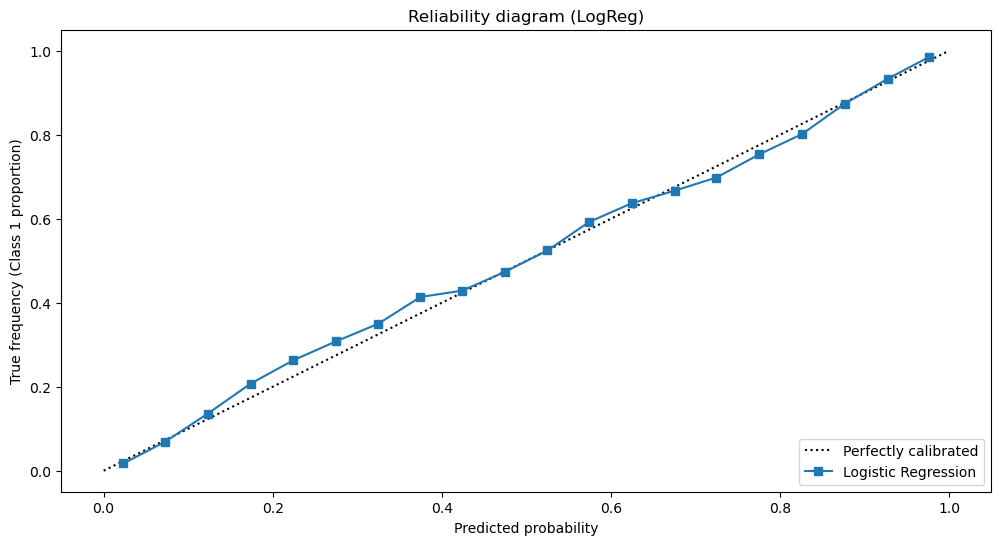

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

CalibrationDisplay.from_predictions(
    y_test,
    log_preds[:,1],
    n_bins=20,
    ax=ax,
    strategy="uniform",
    name="Logistic Regression",
)
ax.set_title('Reliability diagram (LogReg)')
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True frequency (Class 1 proportion)")
plt.show()

In [8]:
brier_logreg = brier_score_loss(y_test, log_preds[:,1])
print(f"Brier Loss: {brier_logreg:.4f}")

Brier Loss: 0.1044


### Analysis of results

#### 1) Reliability diagram:
   
* Perfectly Calibrated is represented by a dotted diagonal line (“Perfectly Calibrated”).
* Our logistic regression (blue line) shows an almost perfect fit to the diagonal.

##### What does this mean?

Unlike the SVM S-curve, here the graph shows that the predicted probabilities are very **"fair"**:
When the model predicts **~0.2**, the true rate of class 1 is indeed **~20%**.
When it predicts **~0.8**, the true frequency is **~80%**.
This is the "natural" calibration that was mentioned in the unit description. The model does not overestimate or underestimate its confidence, since its loss function (LogLoss) directly penalizes it for this.

---

#### 2) Metric (Brier Score):

We received a Brier Loss of **0.1044**.
This figure is slightly worse (higher) than the Brier Loss of the uncalibrated SVM (0.0861).
Paradox analysis:
This is a key point that illustrates the difference between calibration and discrimination. Brier Score is a composite metric that measures both.

* Discrimination: SVM with rbf kernel (nonlinear model) was much better at separating nonlinear moons than simple linear logistic regression. This improved (lowered) SVM's Brier Score.

* Calibration: Logistic regression had perfect calibration, while SVM had very poor calibration.
SVM's Brier score (0.0861) was lower because its superior discrimination "compensated" for its terrible calibration. LogReg's score (0.1044) was slightly higher because its poor discrimination (linear model on nonlinear data) outweighed its perfect calibration

# What is more important: calibration or discrimination?
Logistic regression has proven to be a “naturally” calibrated model—its probabilities can be trusted. However, comparing Brier Score with SVM shows that a model cannot be judged by just one metric. SVM was better at distinguishing between classes, but its confidence was useless, while LogReg was worse at distinguishing between classes, but was completely “honest” about its uncertainty.
So, what is more important and in what cases?

---

#### The next block will present two tasks that will help us go deeper in finding the answer to this question.

Logistic regression has proven to be a “naturally” calibrated model—its probabilities can be trusted. However, comparing Brier Score with SVM shows that a model cannot be judged by just one metric. SVM was better at distinguishing between classes, but its confidence was useless, while LogReg was worse at distinguishing between classes, but was completely “honest” about its uncertainty.
So, what is more important and in what cases?

---

#### The next block will present two tasks that will help us go deeper in finding the answer to this question.

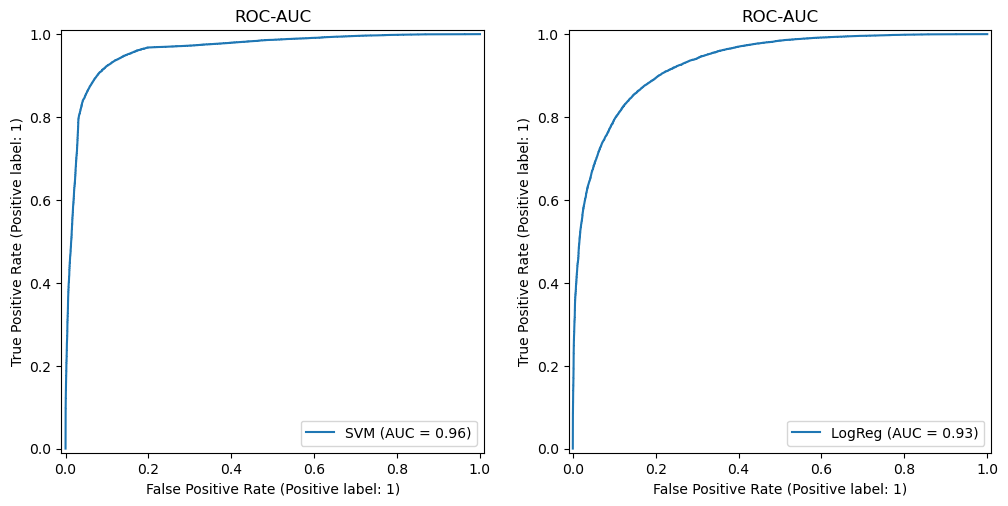

In [9]:
fig, ax = plt.subplots(1,2, figsize =(12,6))
RocCurveDisplay.from_predictions(y_test,y_pseudo_proba, name="SVM", ax=ax[0])
ax[0].set_title('ROC-AUC')
RocCurveDisplay.from_predictions(y_test, log_preds[:,1], name="LogReg", ax=ax[1])
ax[1].set_title('ROC-AUC')

### You are observing a classic paradox:
Even though the SVM (Block 3) has a terrible calibration (S-shaped curve), its overall Brier Score (0.0861) was better (lower) than the perfectly calibrated Logistic Regression (0.1044).

#### Why is this happening? Brier Score Breakdown:
Brier Score is a “hybrid” metric. It measures the overall root mean square error of your probability forecast. This general error can be mathematically decomposed into three components (you can read more about the Brier formula in the Murphy decomposition):

**`Brier Score = Calibration(Reliability) - Resolution(Discrimination) + Uncertainty(Var(y))`**, but for an intuitive understanding, you can think of 
Brier Score as the sum of errors).

#### Let's apply this to our models:
##### Logistic regression (Brier: 0.1044)
* Calibration Error: Almost 0. Our chart shows perfect alignment with the diagonal. The model is "honest".
* Discrimination Error: Worse than SVM. Our linear model was not able to separate nonlinear “moons” so well, as shown by its AUC of 0.93, which is lower than that of SVM.
* Bottom line: This model's Brier Score (0.1044) consists almost entirely of a penalty for poor discrimination.
##### Uncalibrated SVM (Brier: 0.0861)
* Calibration Error: High. The S-shaped curve shows that its probabilities are not as reliable.
* Discrimination Error: Very low. The nonlinear rbf kernel did an excellent job of separating moons, as evidenced by its high AUC of 0.96.
* Bottom Line: The model received a low (good) Brier Score because its excellent discrimination more than compensated for its terrible calibration.


##### Answer to the question:
Yes, in this particular case, a small gain in discrimination (0.03 difference in AUC) turned out to be more important for the final Brier Score metric than a huge difference in calibration.

# And how does this issue play out in real-life ML tasks?
We answered the question of whether discrimination or calibration is more important only specifically for our models. But it can be said unequivocally that in real practical tasks, it is impossible to judge the quality of a model based solely on metrics (as in our case, Brier Loss).

---

#### Nevertheless, in the task of predicting the risk of cardiovascular disease, it is clearly important not only that our model is accurate, but also that it is interpretable. Doctors make decisions by weighing up the risks.
For example:

* If the predictions **90%:** Immediate, expensive, and risky surgery is required.

* And if the prediction** is **55%:** Lifestyle changes and drug therapy (“active surveillance”) are required. If the model confuses 55% and 90%, it becomes **dangerous**. We need a model whose “confidence” can be trusted.

Similarly, in the task of spam filtering, it will not matter to us whether the model has **80 or 90 percent** confidence **if it cannot distinguish** spam from non-spam.

---
In the next section, we will present a paradox where a model performs well in terms of theoretical indicators but fails to cope with business tasks.

# Block 5: When calibration is more important
Let's consider the example above about the disease. 
The dataset is taken from here: `https://www.kaggle.com/datasets/yasserh/heart-disease-dataset`.


Our task is to determine whether the patient **has heart pain or not.**
In medical examinations, our model **must be able to adequately assess its probabilities.**


---

Afterword: We will not seek the optimal solution to the problem, so this section will not provide a detailed analysis of how to solve the problem from a machine learning perspective. We will train a simple model (SVM) without unnecessary heuristics and look at the logical conclusion from it.

In [10]:
df = pd.read_csv("heart.csv")

'''
#   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  // Patient's Age
 1   sex       303 non-null    int64  // Patient's Gender
 2   cp        303 non-null    int64  // Patient's CP Level
 3   trestbps  303 non-null    int64  // Patient's Trest BPS Level
 4   chol      303 non-null    int64  // Patient's Cholestrol Level
 5   fbs       303 non-null    int64  // Patient's FBS Level
 6   restecg   303 non-null    int64  // Patient's Resting ECG Levels
 7   thalach   303 non-null    int64  // Patient's Thalach Levels
 8   exang     303 non-null    int64  // Patient's Exang Levels
 9   oldpeak   303 non-null    float64 // Patient's Old Peak History Recorded
 10  slope     303 non-null    int64  // Patient's Slope Levels
 11  ca        303 non-null    int64  // Patient's CA Levels
 12  thal      303 non-null    int64  // Patient's Thal Levels
 13  target    303 non-null    int64  // 0 - Healthy Individual 1 - Heart-Disease Patient
dtypes: float64(1), int64(13)

---
where "target" = 1: 165, (0.54%)
where "target" = 0: 138, (0.46%)
---

---
df.isna().any():
age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool
'''

scaler = StandardScaler()
cols_to_scale = ["age", "trestbps", "chol", "thalach", "oldpeak"]
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

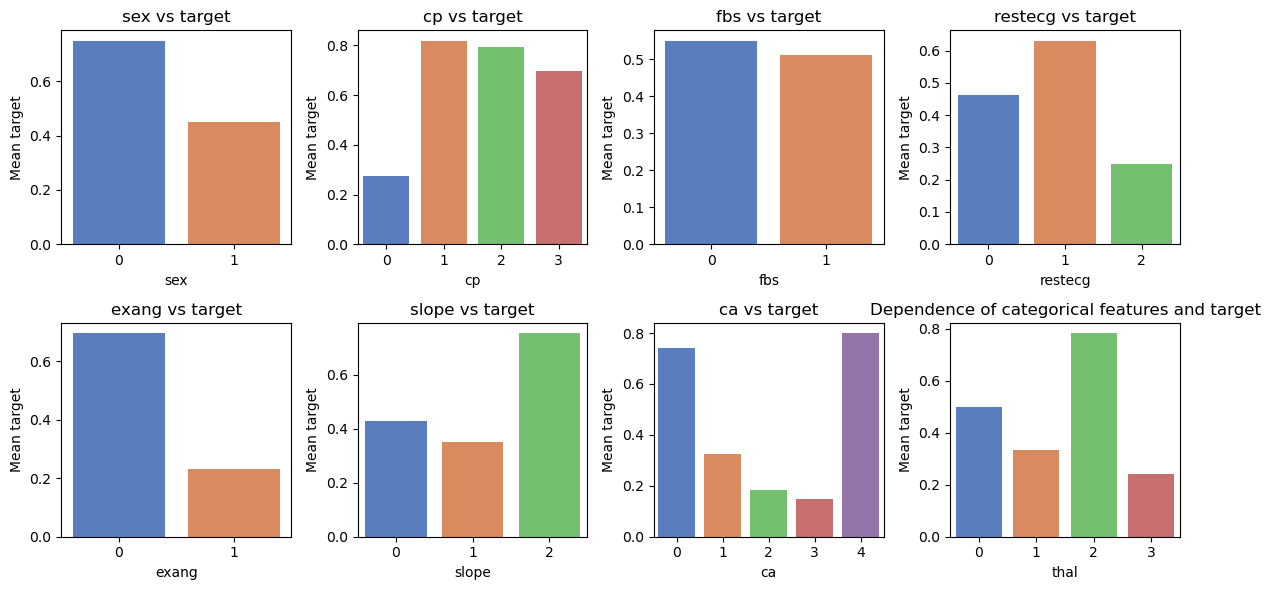

<Figure size 640x480 with 0 Axes>

In [11]:
fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(12,6))
cols = ["sex", "cp","fbs","restecg","exang","slope","ca","thal"] # Although the attributes have the int64 type, they are actually discrete, so they are categorical.
ax = ax.flatten()
for i, col in enumerate(cols):
    dependence = df_scaled.groupby(col)["target"].mean().reset_index()
    sns.barplot(data=dependence, x=col, y='target', palette='muted',ax=ax[i])
    ax[i].set_title(f"{col} vs target")
    ax[i].set_ylabel("Mean target")

plt.tight_layout()
plt.title("Dependence of categorical features and target")
plt.show()    


### Several clear and interpretable patterns can be identified based on categorical variables:
* Women (gender = 0) have a significantly higher average prevalence of heart disease compared to men.
* Patients with atypical, non-anginal, or asymptomatic chest pain (cp = 1–3) have a significantly higher incidence than patients with typical angina (cp = 0).
* The fbs results show that there is almost no significant difference between 0 and 1. There are already so many features for all 303 samples, so we will remove this insignificant feature in the pipeline.
* Resting ECG results also differentiate risk: individuals with ST-T abnormalities (restecg = 1) have the highest probability of disease, while normal ECGs (restecg = 0) correspond to moderate risk.
* Exercise-induced angina (exang = 1) is associated with a significantly reduced likelihood of disease, suggesting that the absence of such angina is more indicative of underlying pathology.
* The slope reflects a clear monotonic pattern, with ascending ST segments (slope = 2) associated with the highest prevalence.
* The number of large vessels (ca) is strongly inversely related to the probability of disease, with ca = 0 being most indicative of heart disease and higher values sharply reducing the risk.
* Finally, thal demonstrates clear categorization, with reversible defects (thal = 2) showing the highest probability of disease, while fixed or normal thallium scan results correspond to a significantly lower risk. Overall, categorical predictors demonstrate clear and clinically meaningful stratification of the target.

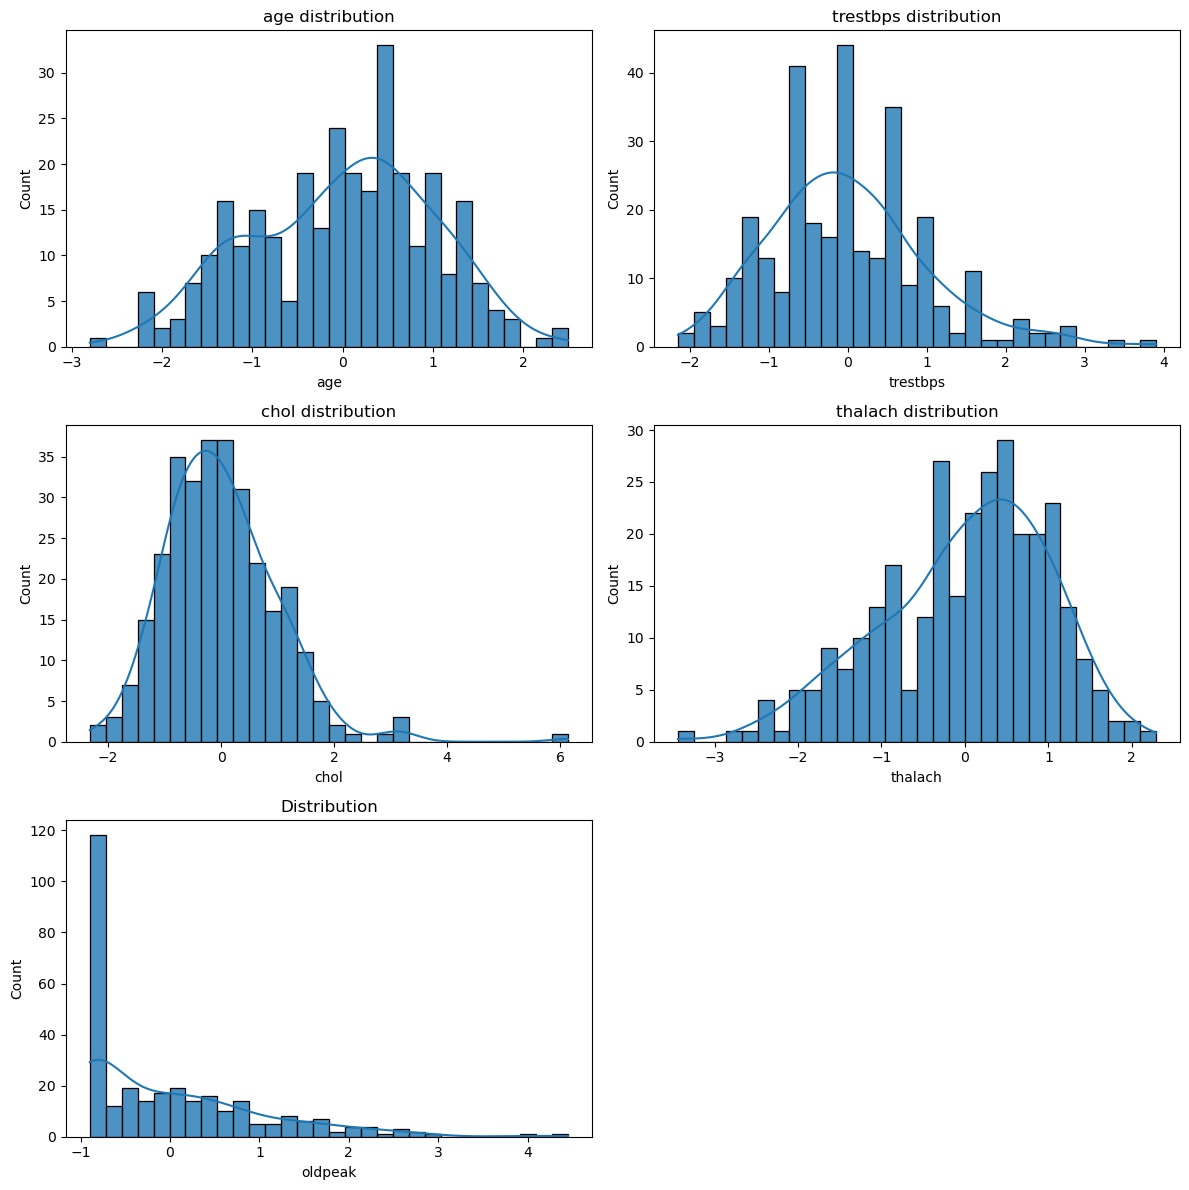

<Figure size 640x480 with 0 Axes>

In [12]:
cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(12,12))
ax = ax.flatten()
for i, col in enumerate(cols):
    sns.histplot(data=df_scaled[col],kde=True, bins=30,alpha=0.8, palette='muted',ax=ax[i])
    ax[i].set_title(f"{col} distribution")
    ax[i].set_ylabel("Count")

for j in range(len(cols), 3*2):
    fig.delaxes(ax[j])
    
plt.tight_layout()
plt.title("Distribution")
plt.show()

### Distribution characteristics
#### Age

* Approximately normal distribution with slight right-sided asymmetry.
* Center around 0 (data likely standardized).
* Relatively symmetrical, indicating a balanced sample in terms of age.

#### Trestbps (resting blood pressure)

* Close to normal distribution
* Slight right-sided asymmetry
* Good variability of the feature

#### Chol (cholesterol)

* Closest to ideal normal distribution
* Practically symmetrical
* Centered around 0

#### Thalach  (maximum heart rate)

* Close to normal, but with noticeable left-sided asymmetry
* Distribution slightly shifted to the right
* Good data variability

#### Oldpeak (ST segment depression)

* Highly asymmetric distribution with a pronounced right “tail”
* Most values concentrated around -1
* Presence of outliers or rare extreme values
* This is a sign of high importance, as abnormal distribution often indicates a strong connection with the target variable

---

### Conclusions about the importance of features
**Potentially most important:**

* oldpeak - strong asymmetry indicates that this feature can separate classes well
* thalach - asymmetry may indicate diagnostic value

**Medium importance:**

* age, trestbps - normal distributions, but may still be informative

**Potentially less important:**

* chol - too perfect a normal distribution may mean less discriminatory powertribution may mean less discriminatory power

In [18]:
# 1. Defining features
X = df.drop('target', axis=1)
y = df['target']

# Scaling indicators (chol removed)
numeric_features = ['age', 'trestbps', 'thalach', 'oldpeak'] 
# Features that we leave as is
categorical_features = ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']
# Features to be removed (chol added)
drop_features = ['fbs', 'chol']

# 2. Creating a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features),
        ('drop', 'drop', drop_features)
    ],
    remainder='drop'
)

# 3. Creating a complete pipeline with SVC
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# 4. Split data and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf.fit(X_train, y_train)
print('Training complete.')

# 5. Obtaining predictions and probabilities
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1] # Probabilities for class 1

Training complete.


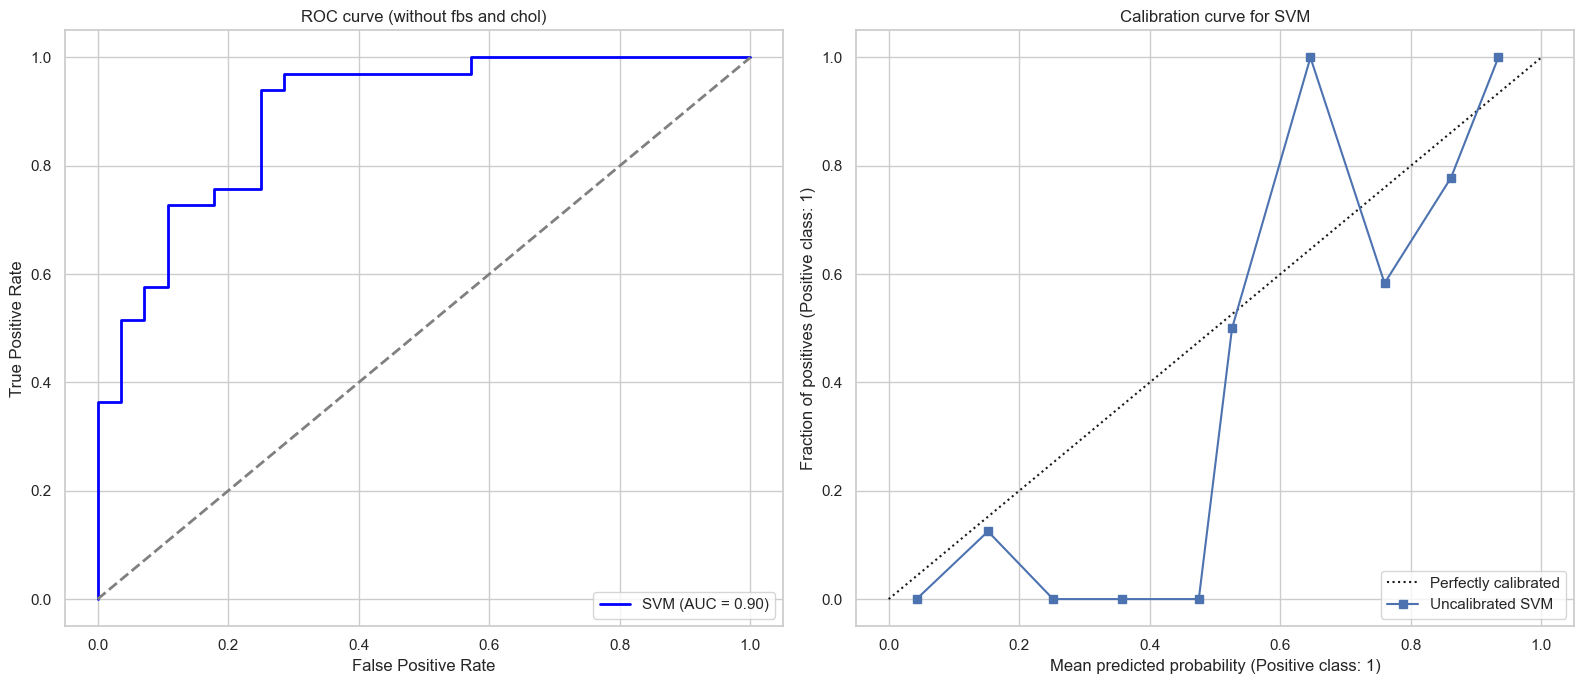

<Figure size 640x480 with 0 Axes>

In [21]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# --- Graph 1: ROC curve (ax[0]) ---
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc_value = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color="blue", lw=2, label=f'SVM (AUC = {roc_auc_value:.2f})')
ax[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC curve (without fbs and chol)')
ax[0].legend(loc='lower right')

# --- Graph 2: Calibration curve (ax[1]) ---
display = CalibrationDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    n_bins=10,
    strategy='uniform',
    ax=ax[1],
    name=f'Uncalibrated SVM'
)

ax[1].set_title('Calibration curve for SVM')

plt.tight_layout()
plt.show()


### Analysis
The illusion of accuracy (Block 5 analysis):
Our graphs tell the story of the **“metrics trap”** — a phenomenon where the pursuit of a high score on one metric hides fatal flaws in another that is critical to the business objective.

* On the one hand (left graph), we see a triumph:
ROC AUC = 0.90. This is an excellent result. It tells us that our model has high discriminatory power. That is, if we take a random sick patient and a random healthy patient, in 90% of cases, the model will correctly assign the sick patient a higher probability of disease. For many tasks (such as spam filtering or search query ranking), this would be a victory.

* On the other hand (right graph), we see a disaster:

The calibration curve shows a complete disconnect between the model's predictions and reality. An ideal model should lie on the dotted diagonal (where 40% of the prediction means 40% of the actual risk).

Our model (blue line) shows not just an S-shaped curve, but chaotic, dangerous behavior.
The most striking example:
When the model predicts a risk of ~55% (point 0.55 on the X-axis), the actual proportion of positive cases (Y-axis) for these patients is 80%.

---

#### What does this mean in practice? Let's return to our example with the doctor.

The doctor sees the model's prediction of 55%. According to the protocol (“active surveillance”), he prescribes a change in diet and drug therapy for the patient. But in reality, according to the calibration, almost every patient who is given a “55%” by this model has the disease. The patient required immediate, albeit risky, surgery, but did not receive it.

---

##### Despite its high AUC, the SVM model proved to be completely unsuitable and dangerous for this task, as its “confidence” cannot be trusted. It perfectly distinguishes between sick and healthy patients, but completely fails to understand the degree of risk.

# Block 6: Conclusion

### Metrics are a tool, not a goal

This experiment clearly demonstrates a fundamental truth of machine learning: **there is no universally “good” model or “best” metric**. Everything is determined solely by the context of the task.

#### Context is king.
The first question we should ask is not "What is our AUC?" but "How will our prediction be used?"

* Discrimination task (as in a spam filter): We don't care if the model is 80% or 90% confident about spam. What matters to us is that it simply distinguishes spam from non-spam. Here, ROC AUC and Precision-Recall are our main indicators.
* 
* Risk assessment task (medicine, insurance, loans): It is vitally important to us that 5% risk means exactly 5% risk. Here, calibration and metrics such as Brier Loss or Log Loss (which heavily penalizes overconfidence in incorrect predictions) come to the fore.
Metrics can be deceiving. Our case is a classic 'paradox'. We have a model that is both 'excellent' (according to AUC) and 'terrible' (according to calibration). **Blind trust** in one popular metric (AUC) would lead to the introduction of a **dangerous** product.

#### Model evaluation is not just one number.
Evaluating model quality is always a compromise and a multidimensional analysis. We must analyze discrimination, calibration, and business impact (what is the cost of different types of errors?) as a whole.

### In summary, our work shows that blindly 'chasing' high scores on standard metrics without a deep understanding of the task is not only bad practice, but in critical areas such as medicine, it is a direct threat.hole.
